<a href="https://colab.research.google.com/github/SrBergstrom/Reconocedor_de_digitos/blob/main/Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.chdir('/content/drive/My Drive/Maestria/02/')


In [ ]:
# ! ls

In [ ]:
# # Carpeta para credenciales de Kaggle
# !mkdir -p ~/.kaggle

# # Archivo kaggle.json
# !cp kaggle.json ~/.kaggle/

# # Permisos
# !chmod 600 ~/.kaggle/kaggle.json

# # Descargar el dataset desde Kaggle
# !kaggle competitions download -c digit-recognizer --force


In [ ]:
# # Descomprimir archivo ZIP
# !unzip digit-recognizer.zip


In [ ]:
# # Instalación de TensorFlow (incluye Keras)
# !pip install tensorflow


In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Importamos bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# Importamos TensorFlow y Keras
import tensorflow as tf                           # Biblioteca principal de TensorFlow
from tensorflow.keras.utils import to_categorical # Conversión de etiquetas a formato categórico
from tensorflow.keras.models import Sequential    # Modelo secuencial
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPool2D   # Capas del modelo
)
from tensorflow.keras.optimizers import RMSprop   # Optimizador RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Aumento de datos de imágenes
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Ajuste de tasa de aprendizaje



In [ ]:
# Carga de datos
train = pd.read_csv("train.csv")  # Conjunto de datos de entrenamiento
test = pd.read_csv("test.csv")     # Conjunto de datos de prueba


Distribución de clases:
 label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


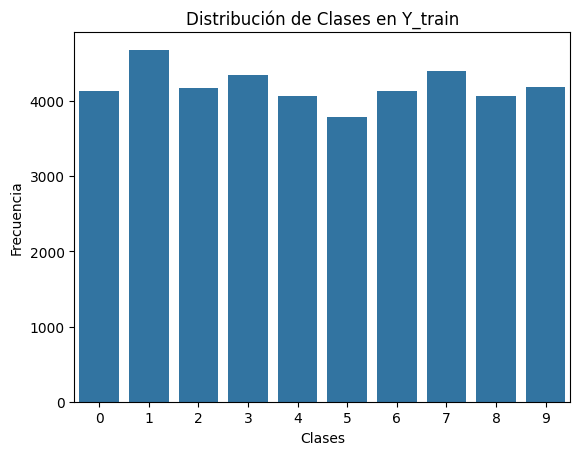

In [ ]:
# Asignación de la columna de etiquetas a Y_train
Y_train = train["label"]  # Etiquetas del conjunto de entrenamiento

# Eliminación de la columna 'label' de los datos de entrada
X_train = train.drop(columns="label")  # Datos de entrada sin la columna de etiquetas

# Visualización de la distribución de las clases en Y_train
class_distribution = Y_train.value_counts()  # Conteo de clases
print("Distribución de clases:\n", class_distribution)  # Impresión de la distribución

# Gráfico de distribución
sns.countplot(x=Y_train)  # Gráfico de barras de la frecuencia de clases
plt.title("Distribución de Clases en Y_train")  # Título del gráfico
plt.xlabel("Clases")  # Etiqueta del eje X
plt.ylabel("Frecuencia")  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico


In [ ]:
# Verificación de datos
null_check = X_train.isnull().any()  # Comprobación de valores nulos en X_train
null_summary = null_check.describe()  # Resumen de la verificación de valores nulos
print(null_summary)


count       784
unique        1
top       False
freq        784
dtype: object


In [ ]:
# Verificación de datos en el conjunto de prueba
null_check_test = test.isnull().any()  # Comprobación de valores nulos en el conjunto de prueba
null_summary_test = null_check_test.describe()  # Resumen de la verificación de valores nulos en el conjunto de prueba
null_summary_test  # Resultado de la verificación


,0
count,784
unique,1
top,False
freq,784


In [ ]:
# Normalización de los datos
X_train = X_train / 255.0  # Escalado de datos de entrenamiento a rango [0, 1]
test = test / 255.0         # Escalado de datos de prueba a rango [0, 1]


In [ ]:
# Reestructuración de imágenes en 3 dimensiones (altura = 28px, ancho = 28px, canal = 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)  # Reestructuración de datos de entrenamiento
test = test.values.reshape(-1, 28, 28, 1)         # Reestructuración de datos de prueba


In [ ]:
# Codificación de etiquetas a vectores one-hot (ejemplo: 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
Y_train = to_categorical(Y_train, num_classes=10)  # Conversión de etiquetas en one-hot


In [ ]:
# Establecimiento de la semilla aleatoria
random_seed = 2  # Semilla para reproducibilidad


In [ ]:
# División del conjunto de entrenamiento y el conjunto de validación
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)  # Separación en conjuntos de entrenamiento y validación


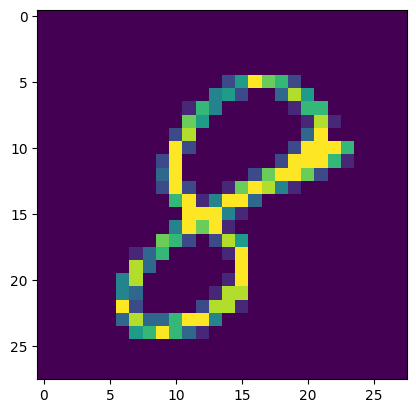

In [ ]:
# Ejemplos de imágenes
g = plt.imshow(X_train[0][:, :, 0])  # Visualización de la primera imagen del conjunto de entrenamiento


In [ ]:
# Arquitectura de la CNN
model = Sequential()  # Inicialización del modelo secuencial

# Primera capa convolucional
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)) )  # Capa Conv2D con 32 filtros
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))  # Segunda capa Conv2D
model.add(MaxPool2D(pool_size=(2, 2)))  # Capa de max pooling
model.add(Dropout(0.25))  # Capa de Dropout

# Segunda sección convolucional
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))  # Tercera capa Conv2D
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))  # Cuarta capa Conv2D
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))  # Capa de max pooling
model.add(Dropout(0.25))  # Capa de Dropout

# Capa de aplanamiento y capas densas
model.add(Flatten())  # Aplanamiento de la entrada
model.add(Dense(256, activation="relu"))  # Capa densa con 256 neuronas
model.add(Dropout(0.5))  # Capa de Dropout
model.add(Dense(10, activation="softmax"))  # Capa de salida con 10 neuronas (clases)


In [ ]:
# Definición del optimizador
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)  # Inicialización del optimizador RMSprop


In [ ]:
# Compilación del modelo
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])  # Configuración del modelo para el entrenamiento


In [ ]:
# Establecimiento de un disminuidor de la tasa de aprendizaje
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',  # Monitoreo de la precisión de validación
                                            patience=3,  # Paciencia antes de reducir la tasa de aprendizaje
                                            verbose=1,  # Detalles del proceso de reducción
                                            factor=0.5,  # Factor de reducción de la tasa de aprendizaje
                                            min_lr=0.00001)  # Tasa de aprendizaje mínima


In [ ]:
# Definición de parámetros de entrenamiento
epochs = 1  # Número de épocas de entrenamiento; cambiar a 30 para alcanzar una precisión de 0.9967
batch_size = 86  # Tamaño del lote para el entrenamiento


In [ ]:
# Aumento de datos para prevenir el sobreajuste
datagen = ImageDataGenerator(
        featurewise_center=False,  # No centrar la media de las características sobre el conjunto de datos
        samplewise_center=False,  # No centrar la media de cada muestra
        featurewise_std_normalization=False,  # No normalizar las entradas por la desviación estándar del conjunto de datos
        samplewise_std_normalization=False,  # No normalizar cada entrada por su desviación estándar
        zca_whitening=False,  # No aplicar blanqueamiento ZCA
        rotation_range=10,  # Rotación aleatoria de imágenes en el rango (grados, 0 a 180)
        zoom_range=0.1,  # Acercar aleatoriamente la imagen
        width_shift_range=0.1,  # Desplazamiento horizontal aleatorio de imágenes (fracción del ancho total)
        height_shift_range=0.1,  # Desplazamiento vertical aleatorio de imágenes (fracción de la altura total)
        horizontal_flip=False,  # No voltear las imágenes horizontalmente
        vertical_flip=False)  # No voltear las imágenes verticalmente

datagen.fit(X_train)  # Ajuste del generador a los datos de entrenamiento


In [ ]:
# Ajustar el modelo
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),  # Flujo de datos aumentado
                    epochs=epochs,  # Número de épocas de entrenamiento
                    validation_data=(X_val, Y_val),  # Datos de validación
                    verbose=2,  # Nivel de detalle de salida (2 para una visualización más clara)
                    steps_per_epoch=X_train.shape[0] // batch_size,  # Pasos por época
                    callbacks=[learning_rate_reduction])  # Callback para la reducción de la tasa de aprendizaje


439/439 - 290s - 660ms/step - accuracy: 0.8673 - loss: 0.4113 - val_accuracy: 0.9790 - val_loss: 0.0711 - learning_rate: 0.0010


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


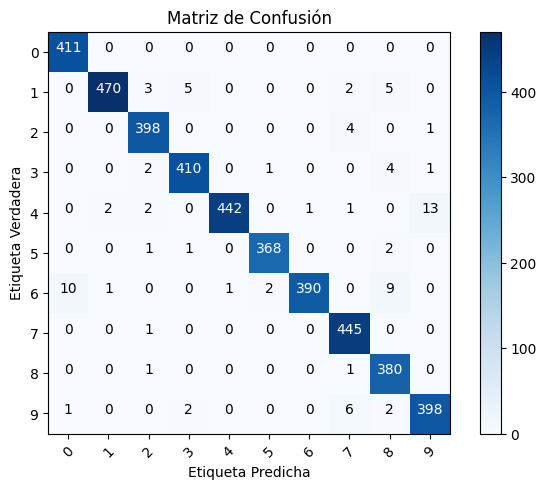

In [ ]:
# Visualización de la matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    Imprimir y graficar la matriz de confusión.
    Normalización se aplica si `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Mostrar la matriz
    plt.title(title)  # Título de la gráfica
    plt.colorbar()  # Barra de color
    tick_marks = np.arange(len(classes))  # Marcas en el eje
    plt.xticks(tick_marks, classes, rotation=45)  # Etiquetas en el eje X
    plt.yticks(tick_marks, classes)  # Etiquetas en el eje Y

    if normalize:  # Normalizar si se indica
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.  # Umbral para el color del texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):  # Recorrer la matriz
        plt.text(j, i, cm[i, j],  # Mostrar el valor en la matriz
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()  # Ajustar diseño
    plt.ylabel('Etiqueta Verdadera')  # Etiqueta del eje Y
    plt.xlabel('Etiqueta Predicha')  # Etiqueta del eje X

# Predicciones del conjunto de validación
Y_pred = model.predict(X_val)  # Realizar predicciones
# Convertir clases predichas a vectores one hot
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Obtener clases predichas
# Convertir observaciones de validación a vectores one hot
Y_true = np.argmax(Y_val, axis=1)  # Obtener clases verdaderas
# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)  # Generar matriz de confusión
# Graficar la matriz de confusión
plot_confusion_matrix(confusion_mtx, classes=range(10))  # Llamar a la función de graficado


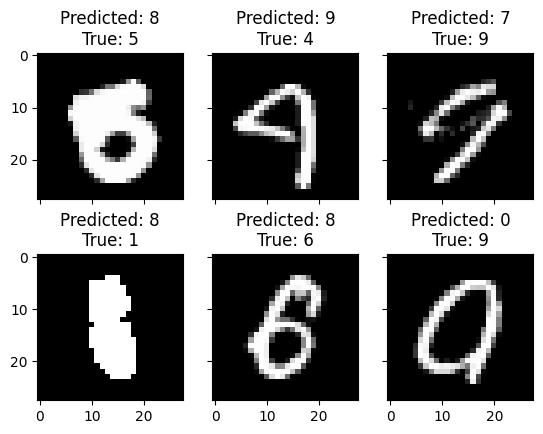

In [ ]:
# Mostrar algunos resultados de errores

# Errores son diferencias entre etiquetas predichas y verdaderas
errors = (Y_pred_classes - Y_true != 0)  # Identificar errores

# Filtrar las clases, probabilidades y datos de entrada con errores
Y_pred_classes_errors = Y_pred_classes[errors]  # Clases predichas erróneas
Y_pred_errors = Y_pred[errors]  # Probabilidades predichas erróneas
Y_true_errors = Y_true[errors]  # Clases verdaderas de los errores
X_val_errors = X_val[errors]  # Datos de entrada erróneos

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ Muestra 6 imágenes con sus etiquetas predichas y reales """
    n = 0
    nrows = 2  # Número de filas
    ncols = 3  # Número de columnas
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)  # Crear subgráficas
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]  # Índice de error
            ax[row, col].imshow(img_errors[error].reshape((28, 28)), cmap='gray')  # Mostrar imagen
            ax[row, col].set_title(f"Predicted: {pred_errors[error]}\nTrue: {obs_errors[error]}")  # Títulos
            n += 1

# Probabilidades de los números mal predichos
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)  # Máxima probabilidad predicha

# Probabilidades predichas de los valores verdaderos en el conjunto de errores
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))  # Probabilidad verdadera

# Diferencia entre la probabilidad de la etiqueta predicha y la verdadera
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors  # Calcular diferencias

# Lista ordenada de las diferencias de probabilidades
sorted_delta_errors = np.argsort(delta_pred_true_errors)  # Ordenar errores

# Top 6 errores
most_important_errors = sorted_delta_errors[-6:]  # Errores más importantes

# Mostrar los 6 errores más relevantes
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)  # Llamar a la función


In [ ]:
# Predecir los resultados para el conjunto de prueba
results = model.predict(test)  # Usar el modelo para hacer predicciones

# Seleccionar el índice con la máxima probabilidad
results = np.argmax(results, axis=1)  # Obtener la clase con la mayor probabilidad para cada predicción

# Convertir los resultados a una serie de pandas con el nombre "Label"
results = pd.Series(results, name="Label")  # Crear una serie de pandas para facilitar su uso


875/875 ━━━━━━━━━━━━━━━━━━━━ 57s 65ms/step


In [ ]:
# Crear el DataFrame para la presentación
submission = pd.DataFrame({
    "ImageId": range(1, 28001),  # Generar un rango de 1 a 28000 para las IDs de imagen
    "Label": results  # Asignar los resultados como la columna 'Label'
})

# Mostrar las últimas filas del DataFrame
submission.tail()  # Esto te permite ver las últimas filas para confirmar que los datos se han agregado correctamente


,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


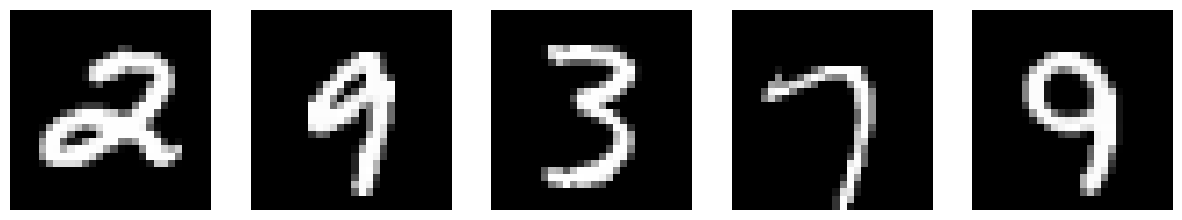

In [ ]:
import matplotlib.pyplot as plt

# Mostrar las últimas 5 imágenes test
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    axes[i].imshow(test[-(i + 1)][:, :, 0], cmap='gray')  # Ajusta el índice para mostrar imágenes en orden
    axes[i].axis('off')  # Ocultar los ejes

plt.show()


In [ ]:
model.save('modelo_digit_recognizer.h5')


In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('modelo_digit_recognizer.h5')
